# Even more NYC rent exploration

In the last notebook, we got a bunch of experience with the basic exploratory analysis tools and did some plotting.  There's a lot more we can learn from the data set, so let's jump in!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%config InlineBackend.figure_format = 'svg'   # svg vs png format make sharper images!
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points

In [2]:
df_rent = pd.read_json('data/train.json')

## Cleaning up

Let's go through and clean up the data set to remove obviously incorrect or inappropriate or missing data.

<img src="images/redbang.png" width="30" align="left">We view all data cleaning operations through the lens of what exactly we want a predictive model to do or what our business use-case is. In our case, we care about apartment rent prices and just for New York City and just for the reasonably priced apartments.

We saw in the previous notebook that some of the price values are sale price not rent price so let's start by stripping those out.  Instead of altering the original data frame, let's create a working data frame just called `df`:

In [3]:
df = df_rent[(df_rent['price'] <= 10_000) & (df_rent['price'] > 100)].copy()

 We use a copy so that we avoid errors when we alter this slice of the original `df_rent` data frame.
 
We also discovered a typo (as part of an exercise), an apartment that had 10 bathrooms; since they really meant 1, let's fix that too using the `loc` operation that specifies which row and column:

In [4]:
df.loc[df['bathrooms']==10, 'bathrooms'] = 1

### Restricting data to apartments in New York City

One of our goals is to restrict apartments to just New York City, so let's analyze the data and see what we can learn. [GPS coordinates](https://whatis.techtarget.com/definition/GPS-coordinates) are weird, but they represent degrees difference from "prime Meridian" (Greenwich England). Longitude lines are vertical and indicate +90 to -90 degrees from the prime Meridian. Latitude is zero at the equator and +90 and -90 at the north and south poles.  For example, if we type `40.7530, -73.9982` into Google maps, we get a location on the west side of Manhattan:

<img src="images/nyc.png" width="200">

Cool, so that gives us a general idea of the coordinates of New York City. Note the differences between GPS numbers will be very small. Let's hope for the best and just do a plot with a single per apartment and see what it looks like:

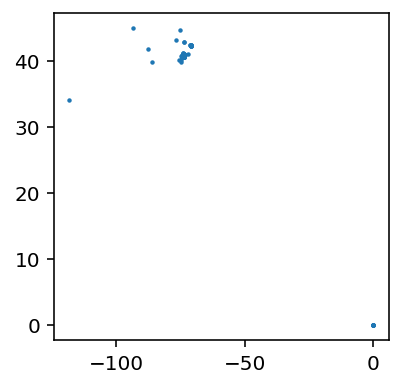

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.scatter(df_rent['longitude'], df_rent['latitude'], s=1.5) # size = 1.5 per dot
plt.show()

Something is definitely wrong with some of the coordinates. Plus, how come there are only a few dots?! Hmm... well, let's examine the values.

In [6]:
df_rent[['longitude','latitude']].describe()

,longitude,latitude
count,49352.000000,49352.000000
mean,-73.955716,40.741545
std,1.177912,0.638535
min,-118.271000,0.000000
25%,-73.991700,40.728300
50%,-73.977900,40.751800
75%,-73.954800,40.774300
max,0.000000,44.883500


Whoa. There are apartments with 0 coordinates!  There is an apartment at GPS coordinates 0,0, which puts it at the equator in the Atlantic Ocean. I think we should assume that apartments with 0 coordinates are "missing" sentinel values, but how big of a problem is it?

In [7]:
sum(df_rent['latitude']==0), sum(df_rent['longitude']==0), len(df_rent)

(12, 12, 49352)

Out of roughly 50,000 records, only 12 of them have these sentinel values, and no doubt it is the same records with both as zero.  If this were banking data and we were looking for anomalous / fraudulent transactions, we absolutely would not want to delete this data. In our case, we could simply go in and look for the address and then ask Google maps for the coordinates:

In [8]:
df_rent[df_rent['latitude']==0]['street_address']

2028             145 28 Street
37426       Van Sicklen street
39134               219 E 28th
46941         1632 Madison Ave
49884           41-42 24th St 
63688     450 East 83rd Street
66197              247 west 87
69423              118 W 109th
70841             246 Mott St 
76934               21 W 106th
85521                338 e. 53
106350      259 Decatur Street
Name: street_address, dtype: object

Equivalently, we could use the `loc` operation:

In [9]:
df_rent.loc[df_rent['latitude']==0, 'street_address']

2028             145 28 Street
37426       Van Sicklen street
39134               219 E 28th
46941         1632 Madison Ave
49884           41-42 24th St 
63688     450 East 83rd Street
66197              247 west 87
69423              118 W 109th
70841             246 Mott St 
76934               21 W 106th
85521                338 e. 53
106350      259 Decatur Street
Name: street_address, dtype: object

On the other hand, it's only a few records and so we are probably okay to omit them from our data set.
 
From [a machine learning book I'm working on](https://mlbook.explained.ai/prep.html): A few apartments have GPS coordinates that put them in Boston, not New York City (for example, latitude, longitude of 40.5813, -74.5343). These coordinates could be typos or just erroneous lookups done by apartment managers. By scrutinizing the records, we could probably figure out whether it's a typo, but there are so few, we can just delete them. New York City does not fit neatly in a square, but we can still decide on a bounding box around it and then delete records outside of that box. A quick check at [gps-coordinates.org](https://gps-coordinates.org/new-york-city-latitude.php), gives a rough outline for New York City of latitude, longitude 40.55, -74.1 on the lower left and 40.94, -73.67 on the upper right. 

Let's revisit querying with dataframes.  If we test a column with a relational operator, the results is a column of Boolean values:

In [10]:
df['latitude']>40.55

4         True
6         True
9         True
10        True
15        True
          ... 
124000    True
124002    True
124004    True
124008    True
124009    True
Name: latitude, Length: 48472, dtype: bool

We can use that column of Boolean values as an index into a data frame. If a value is true, the associated row will appear in the resulting data frame:

In [11]:
bigger = df['latitude']>40.55
df[bigger].head(2).T

,4,6
bathrooms,1,1
bedrooms,1,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712
created,2016-06-16 05:55:27,2016-06-01 05:44:33
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...
display_address,145 Borinquen Place,East 44th
features,"[Dining Room, Pre-War, Laundry in Building, Di...","[Doorman, Elevator, Laundry in Building, Dishw..."
latitude,40.7108,40.7513
listing_id,7170325,7092344
longitude,-73.9539,-73.9722


Or, we can combine it with single expression:

In [12]:
df[df['latitude']>40.55].head(2).T

,4,6
bathrooms,1,1
bedrooms,1,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712
created,2016-06-16 05:55:27,2016-06-01 05:44:33
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...
display_address,145 Borinquen Place,East 44th
features,"[Dining Room, Pre-War, Laundry in Building, Di...","[Doorman, Elevator, Laundry in Building, Dishw..."
latitude,40.7108,40.7513
listing_id,7170325,7092344
longitude,-73.9539,-73.9722


The problem is that we need to indicate the upper bound as well: `df['latitude']<40.94`. How do we combine the lower and upper bounds, and select only those rows? We combined with the `&` (and) operator. And, due to a quirk in the precedence of `&`, we have to put the individual sub expressions in parentheses:

In [13]:
df[(df['latitude']>40.55) & (df['latitude']<40.94)].head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low


But, we also need to restrict the longitude to a range. It looks complicated but it's really just a matter of and'ing together all of the limit operations. We can filter `df` for our full bounding box using::

In [14]:
df = df[(df['latitude']>40.55) &
        (df['latitude']<40.94) &
        (df['longitude']>-74.1) &
        (df['longitude']<-73.67)].copy()
print(len(df), len(df_rent))

48415 49352


Stripping these records is “legal” because they don't fit within the goal previously established for the model. We are not arbitrarily deleting records.

### Exercise 1

Make sure that you can load the original data and create `df` and then clean it up as we've done up to this point.

### Heat map from GPS coordinates

Once we have filtered the GPS coordinates to a reasonable bounding box around New York City, we can try to plot a dot for every apartment.

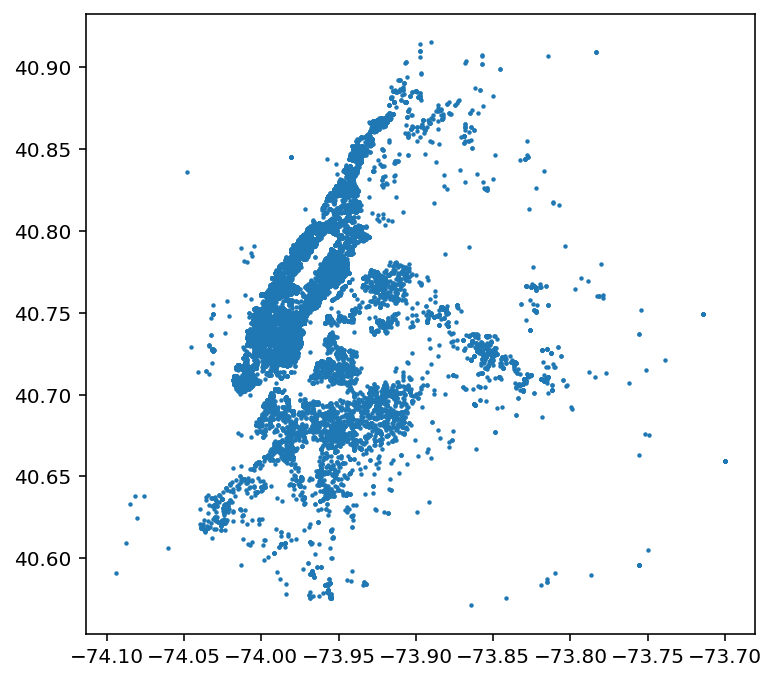

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5.7))
ax.scatter(df['longitude'], df['latitude'], s=1.5) # size = 1.5 per dot
plt.show()

If you are familiar with the outline of Manhattan, you can see it clearly marked. You can even see a rectangular notch in the middle of Manhattan where Central Park is.

We can do a better job than this visualizing the data, however. We can use color to indicate apartment price, mapping low to high as purple to red.  Because of the wide distribution of prices, I set red to be any apartment rent above 4000.

The key difference that makes this scatterplot a heat map is the `cmap` (color map) and `c` (color) parameters.

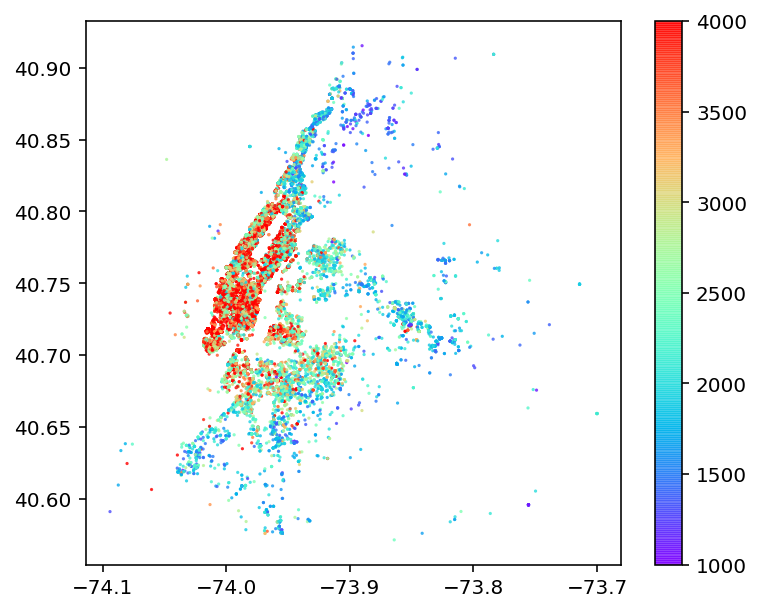

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
m = ax.scatter(df['longitude'],
               df['latitude'],
               alpha=0.8,
               s=1.5, # pixel size
               vmin=1000, vmax=4000, # limit price range so 4000 is red
               c=df['price'],
               cmap='rainbow', # color map
               marker='.')
plt.colorbar(m) # show a color bar on the right using data from the scatterplot
plt.show()

### Exercise 2

Draw the heatmap as shown but you can try another colormap if you like and play with vmin,vmax to adjust coloring.

## Does advertisement creation day-of-week matter?

*Sounds ridiculous, right? But, bear with me!*

We often think of dates as just bookkeeping information about when ads were created, but they hold a wealth of information. For example, interest in an apartment probably wanes over time after its creation.  It could also matter what day of the week the advertisement was posted, which is what we will look at shortly. Keep in mind that if there are dates associated with a sales record in some other data set, holidays and weekends might matter.

The first thing we have to do is to tell pandas that the `created` column is a bunch of dates rather than strings:

In [17]:
df['created'] = pd.to_datetime(df['created'])

 As we did with strings and categorical variables, there is a datetime access member, `dt`, that we can use to ask questions and extract bits of data. Here is how we extract a new column that consists of the day of week and inject it into the data frame:

In [18]:
df['day'] = df['created'].dt.dayofweek # Monday=0, Sunday=6
df['day']

4         3
6         2
9         1
10        4
15        1
         ..
124000    1
124002    5
124004    1
124008    1
124009    2
Name: day, Length: 48415, dtype: int64

Getting the right number of bins and the right ticks/labels took me a second, but here you go:

[('Mon', 4172.0), ('Tue', 8220.0), ('Wed', 9224.0), ('Thu', 8043.0), ('Fri', 7451.0), ('Sat', 6833.0), ('Sun', 4472.0)]
bins [0 1 2 3 4 5 6 7]


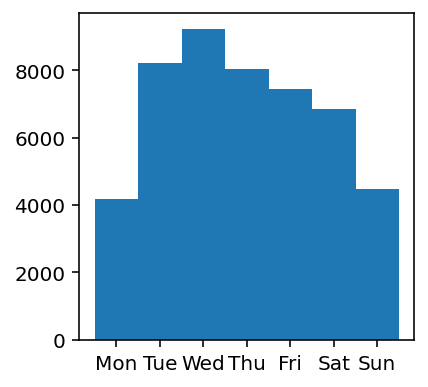

In [62]:
days = ['Mon','Tue','Wed',"Thu",'Fri','Sat','Sun']
fig, ax = plt.subplots(figsize=(3,3))
n, bins, _ = ax.hist(df['day'], bins=range(7+1), align='left') # must include 8 bin edges to get 7 bins
print(list(zip(days,n)))
print("bins", bins)
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon','Tue','Wed',"Thu",'Fri','Sat','Sun'])
plt.show()

Since that took me a second to figure out the right bins, let's use pandas itself to quickly get the count of records for each day:

In [78]:
daycounts = df.groupby('day').count()['price'] # picking price column arbitrarily
daycounts

day
0    4172
1    8220
2    9224
3    8043
4    7451
5    6833
6    4472
Name: price, dtype: int64

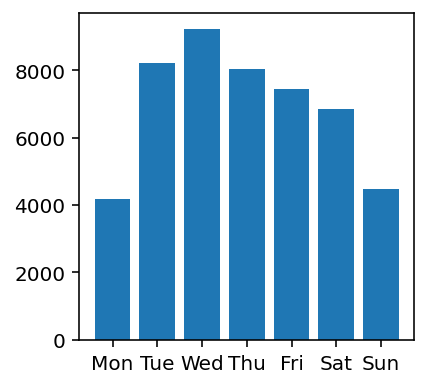

In [80]:
days = ['Mon','Tue','Wed',"Thu",'Fri','Sat','Sun']
fig, ax = plt.subplots(figsize=(3,3))
ax.bar(range(7), daycounts)
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon','Tue','Wed',"Thu",'Fri','Sat','Sun'])
plt.show()

We could do this also using the `cut()` function but it's awkward for discrete integers:

In [71]:
pd.cut(df['day'], bins=range(7), include_lowest=True, right=False).value_counts()

[2, 3)    9224
[1, 2)    8220
[3, 4)    8043
[4, 5)    7451
[5, 6)    6833
[0, 1)    4172
Name: day, dtype: int64

Now, let's compare how much interest there is in an apartment based upon the day of the week. To do that, let's group at first by day and then by interest level and count how many apartments are in that category:

In [81]:
df_counts = df.groupby(['day','interest_level']).count()
df_counts['price'] # pick any category; all have same count values

day  interest_level
0    high               337
     low               2866
     medium             969
1    high               628
     low               5642
     medium            1950
2    high               722
     low               6425
     medium            2077
3    high               636
     low               5521
     medium            1886
4    high               649
     low               4897
     medium            1905
5    high               510
     low               4844
     medium            1479
6    high               351
     low               3179
     medium             942
Name: price, dtype: int64

Once we have that, we can ask for the data as a numpy vector. We can grab the values from any column since they are the same counts:

In [83]:
counts = df_counts['price'].to_numpy()
counts

array([ 337, 2866,  969,  628, 5642, 1950,  722, 6425, 2077,  636, 5521,
       1886,  649, 4897, 1905,  510, 4844, 1479,  351, 3179,  942])

Those counts are for all interest levels and all days jumbled up. There is an obvious stride between the values and so we could use Python to pull those out, but let's use pandas instead to query the index.  Because the index is multivalued (*day*, *interest level*), we use a couple as the index, such as `(2, 'low')` to get the low count for day 2. To do a wildcard like thing, we can use `(range(7), 'low')` to get the low count for all days. The others are similar:

In [150]:
low = df_counts.loc[(range(7), 'low'), 'price'].values
med = df_counts.loc[(range(7), 'medium'), 'price'].values
high = df_counts.loc[(range(7), 'high'), 'price'].values

In [151]:
low, med, high

(array([2866, 5642, 6425, 5521, 4897, 4844, 3179]),
 array([ 969, 1950, 2077, 1886, 1905, 1479,  942]),
 array([337, 628, 722, 636, 649, 510, 351]))

To show multiple bar charts at once, we have to do extra work using the raw matplotlib library. 

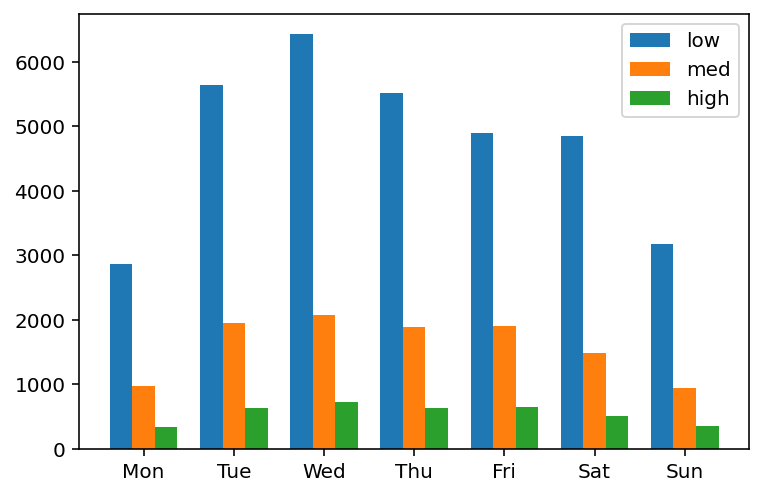

In [145]:
fig, ax = plt.subplots()
w = .25
ax.bar(np.arange(7)-w, low,  width=w, label="low")
ax.bar(np.arange(7),   med,  width=w, label="med")
ax.bar(np.arange(7)+w, high, width=w, label="high")
ax.set_xticklabels([None,'Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.legend() # use labels from bar() calls
plt.show()

So, in the end, it does look like the day of week when the ad was created matters. For example, it looks like the most interest across all  levels occurs for apartments created on Wednesdays. Strange but:

<img src="images/redbang.png" width="30" align="left">Let the data tell the story. Don't start with the story and look for data that supports it!

###  Exercise 3

Use a tuple as an index with `loc[...]` to show the count values for just the low and medium interest apartments.

## Is the apartment manager predictive of rent price?

If a manager is known to manage fancy apartments, that could be correlated strongly with rental price. Let's check to see what the average price per manager is and then get a histogram to see if there is a difference at all between managers.

In [26]:
avg_mgr_prices = df.groupby('manager_id').mean()['price']
avg_mgr_prices

manager_id
0000abd7518b94c35a90d64b56fbf3e6     2706.416667
001ce808ce1720e24a9510e014c69707     3321.500000
003fc4e9a70053082f131b1054966aaf    10000.000000
00607a02f6efd9c6c7c588826e471ee9     2975.000000
00995ff28d79127ed2dca8320e9e7d09     2544.666667
                                        ...     
ff810b43aecfacd00f20a2912ff1e288     3400.000000
ff8f1175d95c5a866ef73399cd54a1a1     4231.428571
ffb9eceeaa4d60da7b41cc8f0954cd50     2422.500000
ffd3c60281949a5cd806030203a79558     3050.200000
ffd7307e4924587b30ec014a95db1362     3591.886957
Name: price, Length: 3415, dtype: float64

Sure enough, there does seem to be a difference in the average apartment price managed by a manager. For example, there are a few managers whose average apartment rent price is 10,000!

The following distribution tells us that knowing the manager gives us a hint to the price of the apartment without knowing anything else, particularly for the right tail of the distribution.

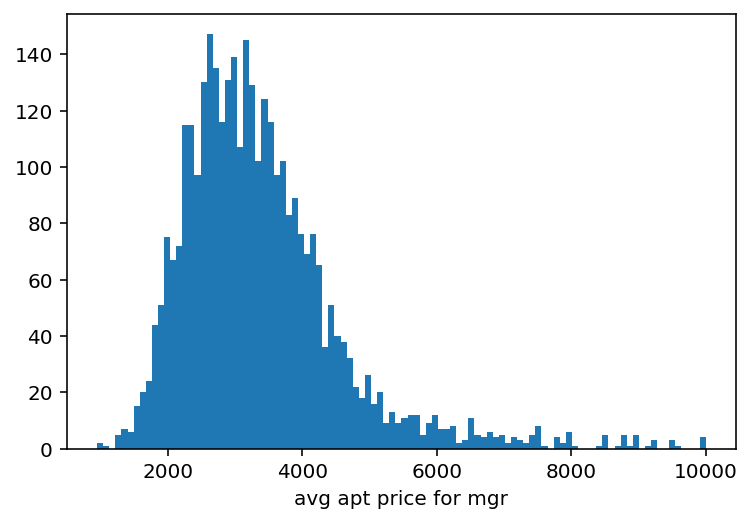

In [161]:
fig, ax = plt.subplots()
ax.hist(avg_mgr_prices, bins=100)
ax.set_xlabel("avg apt price for mgr")
plt.show()

## Are some apartment features valued more than others?

We can measure feature value either by interest level or price, but let's consider what features people are willing to pay for? One way to answer that is to consider the average price for apartments with a particular feature. Averaging across all apartments, will compensate a bit for confounding variables.

There's an issue with the list of features: each list of features is of different length and with different features. It looks like advertisers are typing in whatever they want; for example I see `/LNDRY` as a feature.

Oddly enough, it's easier if we convert this column of `list` objects to strings so that we can use pandas' string functions to ask questions about the features.

In [162]:
df['features'] = df['features'].astype(str)
df['features'] = df['features'].str.lower()
df['features']

4         ['dining room', 'pre-war', 'laundry in buildin...
6         ['doorman', 'elevator', 'laundry in building',...
9         ['doorman', 'elevator', 'laundry in building',...
10                                                       []
15        ['doorman', 'elevator', 'fitness center', 'lau...
                                ...                        
124000        ['elevator', 'dishwasher', 'hardwood floors']
124002    ['common outdoor space', 'cats allowed', 'dogs...
124004    ['dining room', 'elevator', 'pre-war', 'laundr...
124008    ['pre-war', 'laundry in unit', 'dishwasher', '...
124009    ['dining room', 'elevator', 'laundry in buildi...
Name: features, Length: 48415, dtype: object

Now, let's create new columns that indicate whether or not a particular feature is present for the apartment; these are Boolean columns:

In [28]:
df['doorman'] = df['features'].str.contains('doorman')
df['laundry'] = df['features'].str.contains('laundry')
df['parking'] = df['features'].str.contains('parking')
df['hardwood'] = df['features'].str.contains('hardwood')

Then, we can use `groupby` to filter for a particular feature and check prices with and without that feature:

In [29]:
df.groupby('doorman').mean()['price']

doorman
False    3099.578824
True     3936.753628
Name: price, dtype: float64

That's more or less doing following:

In [166]:
df.loc[~df['doorman'], 'price'].mean(), df.loc[df['doorman'], 'price'].mean()

(3099.5788236969524, 3936.753628179269)

In [30]:
df.groupby('laundry').mean()['price']

laundry
False    3155.628269
True     3770.652492
Name: price, dtype: float64

In [31]:
df.groupby('parking').mean()['price']

parking
False    3447.547897
True     3707.196646
Name: price, dtype: float64

In [32]:
df.groupby('hardwood').mean()['price']

hardwood
False    3343.042858
True     3560.034852
Name: price, dtype: float64

It looks to me like, on average, people are willing to pay more for  a doorman, for laundry, and parking. Unfortunately, none of these features is independent. In other words, the more expensive the apartment, the more likely it is to have both a doorman and parking etc.  It doesn't look like there's much of a difference for hardwood floors.   Because of the lack of independence, we should not rely on these relationships, but it does give us some idea of what people are willing to pay for.

## Injecting external neighborhood info

GPS coordinates are very useful, but is there a way we can summarize location in a more important way? Just as in San Francisco, your proximity to a cool neighborhood is important. I found the following cool neighborhoods from an article on the web and manually estimated GPS coordinates for the center of each:

In [33]:
hoods = {
    "hells" : [40.7622, -73.9924],
    "astoria" : [40.7796684, -73.9215888],
    "Evillage" : [40.723163774, -73.984829394],
    "LowerEast" : [40.715033, -73.9842724],
    "UpperEast" : [40.768163594, -73.959329496],
    "financial" : [40.703830518, -74.005666644],
}

Let's inject a new column that represents the L1 Manhattan distance from each apartments coordinates to the center of the cool neighborhoods:

In [167]:
# Distance from each apartment to Hells kitchen ("hells")
np.abs(df.latitude - 40.7622) + np.abs(df.longitude - -73.9924)

4         0.0899
6         0.0311
9         0.0346
10        0.0976
15        0.0364
           ...  
124000    0.1339
124002    0.0922
124004    0.2227
124008    0.0267
124009    0.0240
Length: 48415, dtype: float64

Of course, we want to be more systematic about that and do it for each neighborhood:

In [34]:
for hood,loc in hoods.items():
    # compute manhattan distance from apartment to each neighborhood
    df[hood] = np.abs(df.latitude - loc[0]) + np.abs(df.longitude - loc[1])

Now, we can look at the correlation between neighborhood and price:

In [172]:
for hood,loc in hoods.items():
    corr = np.corrcoef(df[hood], df['price']) # np.corrcoef returns a matrix
    corr = corr[0,1]
    print(f"Hood {hood} correlation with price: {corr:.3f}")

Hood hells correlation with price: -0.321
Hood astoria correlation with price: 0.054
Hood Evillage correlation with price: -0.340
Hood LowerEast correlation with price: -0.326
Hood UpperEast correlation with price: -0.136
Hood financial correlation with price: -0.300


The more strongly negative, the more price falls off as distance to the neighborhood increases.

This print out works, but it's not with the cool kids would do. The cool kids might put that into a data frame for display:

In [187]:
corrs = []
for hood,loc in hoods.items():
    corr = np.corrcoef(df[hood], df['price'])[0,1]
    corrs.append(corr)
df_corr = pd.DataFrame(data=corrs, columns=['correlation'], index=hoods.keys())
df_corr = df_corr.sort_values('correlation')
df_corr

,correlation
Evillage,-0.340208
LowerEast,-0.326255
hells,-0.321355
financial,-0.300369
UpperEast,-0.135940
astoria,0.053675


So it seems that there is some correlation between neighborhood proximity and price, except for UpperEast and Astoria.  Again, keep in mind that these features are not independent. For example, it could be simply that there are only smaller, and therefore less expensive, apartments near Astoria.

While we're at it, let's do a plot showing the relationships. It's a demonstration of an array of plots and how to share axes and how to place text arbitrarily on the graph.

Sidenote: here's how to extract correlation values from the data frame since the index is the neighborhood name (we used `index=hoods.keys()` above):

In [176]:
df_corr.loc['hells']

correlation   -0.321355
Name: hells, dtype: float64

In [178]:
df_corr.loc['hells'][0] # get just the value

-0.32135489797886013

You've seen the subplots function in action before, but this is your first use of `sharey=True, sharex=True`. That just tells it to share x and y labels to make things more compact and also to line things up properly. By using the sorted index, we also show the plots in decreasing order of correlation strength.

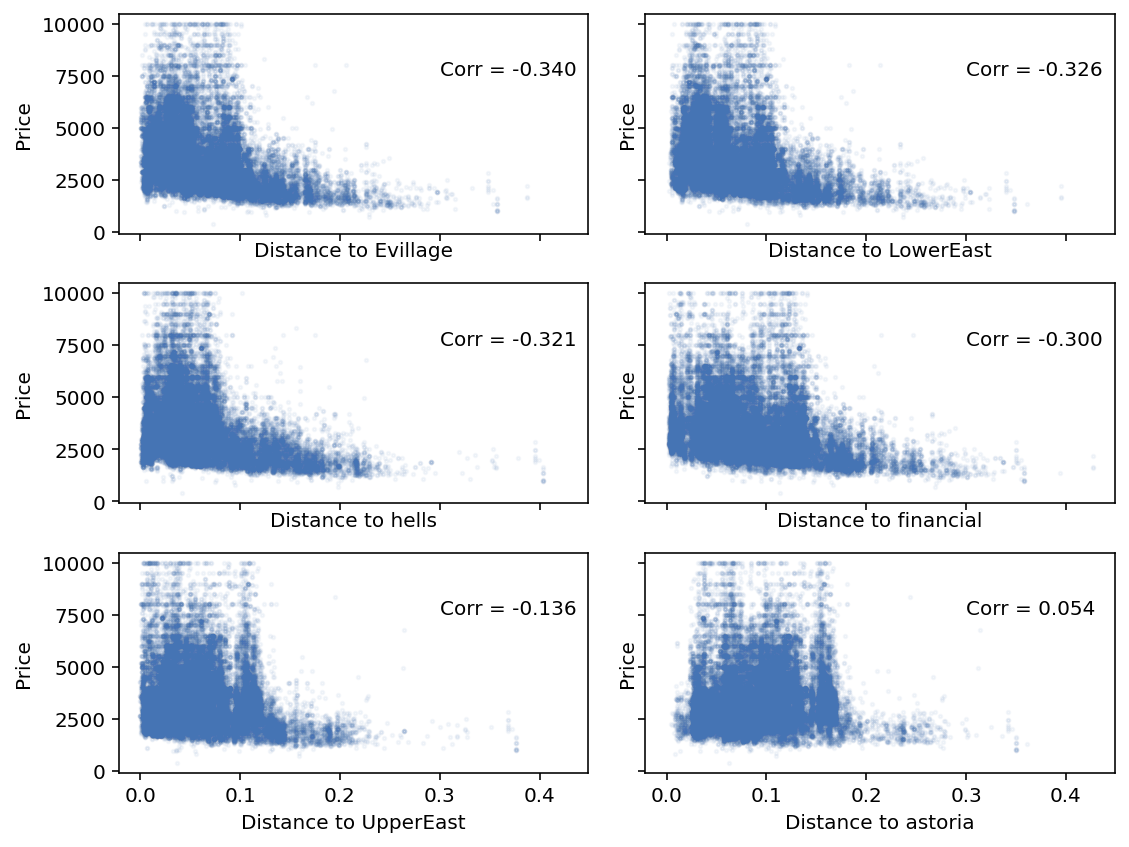

In [188]:
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(8,6), sharey=True, sharex=True)
axes = axes.flatten()
for i,hood in enumerate(df_corr.index):
    axes[i].scatter(df[hood], df['price'], s=3, alpha=.05, c='#4574B4')
    axes[i].set_xlabel(f"Distance to {hood}")
    axes[i].set_ylabel("Price")
    axes[i].text(.3,7500, f"Corr = {df_corr.loc[hood][0]:.3f}")
plt.tight_layout()
plt.show()

### Exercise 4

Make a list of all of the key operations we performed in this notebook. For example, you can give an example of each and then a brief description. The goal here is to get these commands into your brain and the only way to do that is repetition. If you cut-and-paste, you will not learn very quickly at all!